# Laplace Transform in AI Preprocessing — Hands-on Notebook

This notebook shows how to use **Laplace-domain filter design** to preprocess a time-series before model training.

## What you need
```bash
python -m venv .venv && source .venv/bin/activate  # (Windows: .venv\Scripts\activate)
pip install numpy scipy matplotlib scikit-learn
```
(You can also `pip install nbformat` if you want to programmatically generate notebooks.)

**Concept:** We design an *analog* Butterworth low-pass filter in the **Laplace (s-) domain** and map it to a digital filter via the **bilinear transform**. We then filter a noisy signal and show that a simple predictor performs better with the filtered data.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Plotting defaults
%matplotlib inline


## Generate synthetic data

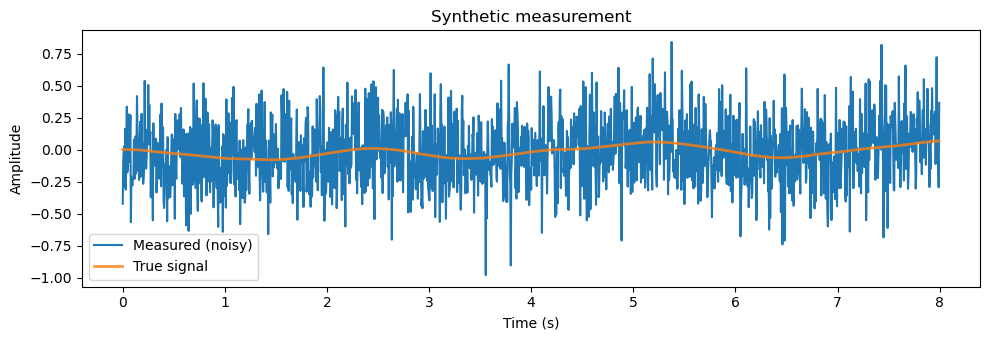

In [2]:
# 1) Generate synthetic dynamics + noise
fs = 200.0
dt = 1.0 / fs
T = 8.0
t = np.arange(0, T, dt)

from scipy import signal
rng = np.random.default_rng(7)
u = signal.lfilter([1.0], [1.0, -0.9], rng.standard_normal(t.size))
u = u / np.max(np.abs(u))

num_ct = [1.0]
den_ct = [1.0, 0.4, 4.0]

A, B, C, D = signal.tf2ss(num_ct, den_ct)
Ad, Bd, Cd, Dd, dt_out = signal.cont2discrete((A, B, C, D), dt, method='zoh')

xk = np.zeros((A.shape[0], ))
y = np.zeros_like(t)
for k in range(len(t)):
    y[k] = (Cd @ xk + Dd * u[k]).reshape(())
    xk = Ad @ xk + (Bd.reshape(-1) * u[k])

true_signal = y

noise = 0.25 * rng.standard_normal(t.size)
measured = true_signal + noise

plt.figure(figsize=(10, 3.5))
plt.plot(t, measured, label="Measured (noisy)")
plt.plot(t, true_signal, label="True signal", linewidth=2, alpha=0.8)
plt.title("Synthetic measurement")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()


## Laplace-domain filter design → digital filtering

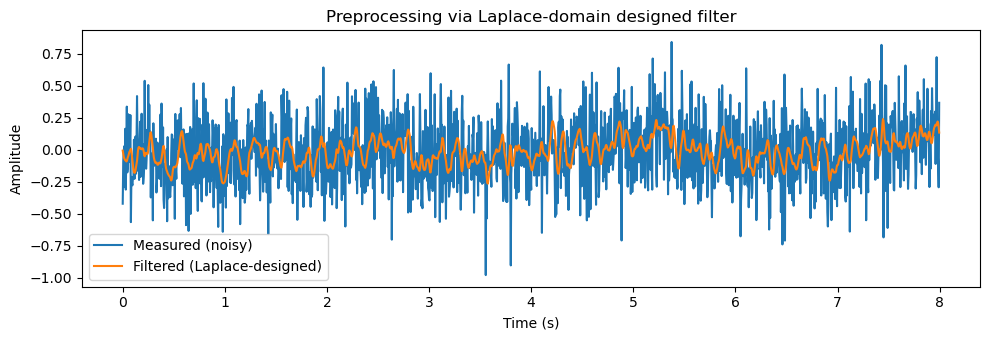

In [3]:
# 2) Laplace-domain design → digital filter (bilinear transform)
order = 2
fc_hz = 10.0
wc = 2.0 * np.pi * fc_hz

b_a, a_a = signal.butter(order, wc, btype='low', analog=True, output='ba')
b_z, a_z = signal.bilinear(b_a, a_a, fs=fs)

filtered = signal.lfilter(b_z, a_z, measured)

plt.figure(figsize=(10, 3.5))
plt.plot(t, measured, label="Measured (noisy)")
plt.plot(t, filtered, label="Filtered (Laplace-designed)")
plt.title("Preprocessing via Laplace-domain designed filter")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()


## Train a tiny predictor (before vs after filtering)

In [4]:
# 3) Simple one-step-ahead regression before vs after filtering
def build_supervised(series, lag=8):
    X, y = [], []
    for i in range(lag, len(series)-1):
        X.append(series[i-lag:i])
        y.append(series[i+1])
    return np.array(X), np.array(y)

lag = 8
X_raw, y_raw = build_supervised(measured, lag=lag)
X_flt, y_flt = build_supervised(filtered, lag=lag)

split = int(0.8 * len(X_raw))
Xr_tr, Xr_te = X_raw[:split], X_raw[split:]
yr_tr, yr_te = y_raw[:split], y_raw[split:]

Xf_tr, Xf_te = X_flt[:split], X_flt[split:]
yf_tr, yf_te = y_flt[:split], y_flt[split:]

model_raw = Ridge(alpha=1.0).fit(Xr_tr, yr_tr)
model_flt = Ridge(alpha=1.0).fit(Xf_tr, yf_tr)

pred_raw = model_raw.predict(Xr_te)
pred_flt = model_flt.predict(Xf_te)

mse_raw = mean_squared_error(yr_te, pred_raw)
mse_flt = mean_squared_error(yf_te, pred_flt)
print("One-step-ahead prediction MSE")
print(f"  • Raw (noisy) input   : {mse_raw:.5f}")
print(f"  • Filtered (preproc.) : {mse_flt:.5f}")


One-step-ahead prediction MSE
  • Raw (noisy) input   : 0.06714
  • Filtered (preproc.) : 0.00162


### Takeaways
- We designed a filter **in the Laplace domain** (continuous-time analog prototype) and then mapped it to a digital filter with the **bilinear transform**.
- This is a common way Laplace-domain methods show up in AI pipelines: as **preprocessing filters** for sensors, audio, time-series, and robotics.
- Cleaner inputs can make simple models (and deep models) **train faster and perform better**.
